In [3]:
import pandas as pd
import numpy as nm
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt

Откроем dataframe и посмотрим содержание командой head

In [4]:
cardio_train = pd.read_csv('cardio_train.csv',sep =';')
cardio_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Видим, что пол у нас явно не обозначен. Для начала проверим, какие вообще значения есть в этой колонке

In [23]:
cardio_train.gender.unique()

array([2, 1])

Видим, что пол обозначен цифрами 1 и 2 и нужно понять, какая цифра какой пол означает. Для этого обратимся к значениям других параметров, во-первых роста и веса. Примем, что в типичной ситуации вес и рост мужчин в среднем больше чем у женщин. Посмотрим моду значений этих колонок, как более устойчивый к выбросам параметр.

In [22]:
cardio_train.groupby('gender').weight.agg(pd.Series.mode)

gender
1    65.0
2    70.0
Name: weight, dtype: float64

In [21]:
cardio_train.groupby('gender').height.agg(pd.Series.mode)

gender
1    165
2    170
Name: height, dtype: int64

Видим, что у пола обозначенного цифрой 2 средние значения роста и веса чуть выше. Однако разница не так уж значительна, так что проверим и другие параметры. Например, для мужчин обычно свойственен более высокий процент курящих и употребляющих алкоголь. Разгруппируем данные по переменной 'gender' и 'alco'/'smoke' и посмотрим соотношение внутри этих категорий.

In [19]:
alco_gender = cardio_train.groupby(['gender','alco']).id.count()
alco_gender / alco_gender.groupby(level=0).sum()

gender  alco
1       0       0.974500
        1       0.025500
2       0       0.893625
        1       0.106375
Name: id, dtype: float64

In [ ]:
c = cardio_train.groupby(['gender','alco']).id.count()

In [18]:
smoke_gender = cardio_train.groupby(['gender','smoke']).id.count()
smoke_gender / smoke_gender.groupby(level=0).sum()

gender  smoke
1       0        0.982144
        1        0.017856
2       0        0.781120
        1        0.218880
Name: id, dtype: float64

Видим, что для пола "2" также показан более высокий процент употребляющих алкоголь (10% против 2,5) и значительно больший процент курящих (21,8% против 1,7%). Исходя из этих данных примем, что "2" это мужчины, а "1" - женщины

In [24]:
cardio_train.loc[cardio_train['gender'] == 1,'gender'] = 'female'
cardio_train.loc[cardio_train['gender'] == 2,'gender'] = 'male'

Теперь для дальнейших рассчетов создадим новую колонку - Индекс массы тела (BMI -вес в килограммах на квадрат роста в метрах)

In [25]:
cardio_train['BMI'] = cardio_train['weight']/(nm.power((cardio_train['height']/100),2))
cardio_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,18393,male,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,20228,female,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,18857,female,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,17623,male,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,17474,female,156,56.0,100,60,1,1,0,0,0,0,23.011177


Посмотрим, как распределена эта переменная и для этого построим график scatterplot. Также сразу разгруппируем данные по цветам на основе пола и по размерам точек на основе возраста, чтобы иметь представление, к каким конкретно категориям относятся выбросы

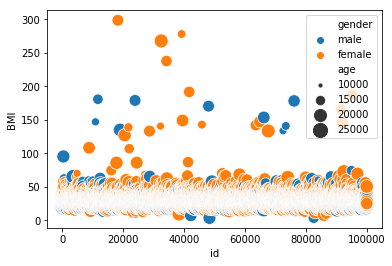

In [26]:
ax = sns.scatterplot(x="id", y="BMI",
                     hue="gender", size="age", sizes=(10, 200),
                     data=cardio_train)

Как мы видим, большинство значений BMI лежит в области до 50, хотя количество наблюдений > 35 (что уже соответствует приличной степени ожирения) довольно высоко. Но тем не менее есть и совсем экстремальные выбросы с BMI > 200,причем только у женщин. Такие значения скорее всего являются ошибочными, так как тогда женщина при росте 1,5 метра должна весить > 400 кг.

Еще одной причиной заподозрить данные в ошибочности может быть факт превышения систолического давления диастолическим, так как в норме эти значения соотносятся как 120 на 80. Уберем из датафрэйма такие наблюдения и проверим, сколько их.

In [27]:
cardio_train_dis_more_sis = cardio_train.drop(cardio_train[cardio_train.ap_lo > cardio_train.ap_hi].index)

In [28]:
dis_more_sis_procent = (cardio_train.shape[0]-cardio_train_dis_more_sis.shape[0])/float(cardio_train.shape[0])*100
dis_more_sis_procent

1.7628571428571427

Видим, что значения, где систолическое давление оказывается ниже диастолического, составляют 1,76%, то есть как минимум в таком проценте наблюдений у нас есть ошибочные данные.

Далее проверим, как распределен в наборе данных уровень холестерина у разных возрастных категорий. Для этого для начала введем колонку с возрастными категориями, где категорию Young у нас будут составлять люди младше 40 (то есть до 14600 дней) и категорию Old люди старше 60 (21900). Все что между отнесем к категории Middle.

In [29]:
cardio_train['age_category'] = cardio_train['age'].apply(lambda x: 'Old' if x > 21900 else ('Young' if x < 14600 else 'Middle age'))
cardio_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,age_category
0,0,18393,male,168,62.0,110,80,1,1,0,0,1,0,21.967120,Middle age
1,1,20228,female,156,85.0,140,90,3,1,0,0,1,1,34.927679,Middle age
2,2,18857,female,165,64.0,130,70,3,1,0,0,0,1,23.507805,Middle age
3,3,17623,male,169,82.0,150,100,1,1,0,0,1,1,28.710479,Middle age
4,4,17474,female,156,56.0,100,60,1,1,0,0,0,0,23.011177,Middle age


Для последующей визуализации распределения уровня холестерина по возрастным категориям создадим также датафрэйм, где посчитаем количество значений для всех возможных групп

In [30]:
cholesterol_and_age = cardio_train.groupby(["cholesterol", "age_category"]).size().reset_index(name='count')

На его основании создадим следующий график

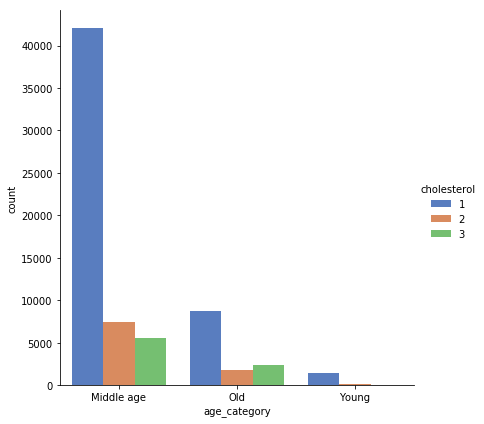

In [31]:
sns.catplot(x="age_category", y="count", hue="cholesterol", data=cholesterol_and_age,
                height=6, kind="bar", palette="muted")

Во-первых, мы видим что большинство исследуемых у нас в принципе относится к возрастной категории между 40 и 60 годами, молодежи довольно мало и среди нее у большинства низкий уровень холестерина (1). Также обращает внимание, что в категории Old высокий уровень холестерина (3) встречается даже чаще, чем средний (2), тогда как для людей среднего возраста это не так.

Далее оценим, а как соотносится индекс массы тела с наличием сердечно-сосудистых заболеваний. В данном датасете сердечными заболеваниями будем считать значения колонки cardio равные "1", а также создадим колонку "hypertonia", в которой присвоим "1" всем тем, у кого значения систолического давления(ap_hi) выше 140 или(и) значения диастолического(ap_lo) выше 90, так как такие показатели являются пороговыми для постановки диагноза "гипертония". 

In [ ]:
def conditions_hypertonia(s):
    if (s['ap_hi'] > 140) or (s['ap_lo'] > 90):
        return 1
    else:
        return 0
cardio_train['hypertonia'] = cardio_train.apply(conditions_hypertonia, axis=1)

Теперь создадим еще одну колонку, где будет 4 возможных значения в зависимости от того, как сочетаются гипертония и сердечные заболевания у исследуемого и назовем ее 'CVD' - cardiovascular disease. 

In [37]:
def conditions_CVD(s):
    if (s['cardio'] ==1 ) and (s['hypertonia'] == 1):
        return 'hyp & card'
    elif (s['cardio'] ==1 ) and (s['hypertonia'] == 0):
        return 'cardio'
    elif (s['cardio'] ==0 ) and (s['hypertonia'] == 1):
        return 'hypertonia'
    elif (s['cardio'] ==0 ) and (s['hypertonia'] == 0):
        return 'No CVD'
cardio_train['CVD'] = cardio_train.apply(conditions_CVD, axis=1)

In [38]:
cardio_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,age_category,hypertony,hypertonia,CVD
0,0,18393,male,168,62.0,110,80,1,1,0,0,1,0,21.967120,Middle age,0,0,No CVD
1,1,20228,female,156,85.0,140,90,3,1,0,0,1,1,34.927679,Middle age,0,0,cardio
2,2,18857,female,165,64.0,130,70,3,1,0,0,0,1,23.507805,Middle age,0,0,cardio
3,3,17623,male,169,82.0,150,100,1,1,0,0,1,1,28.710479,Middle age,1,1,hyp & card
4,4,17474,female,156,56.0,100,60,1,1,0,0,0,0,23.011177,Middle age,0,0,No CVD


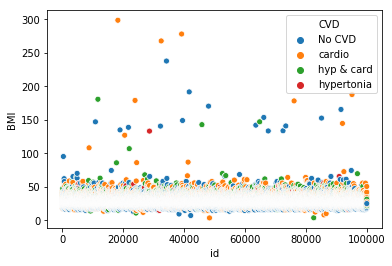

In [39]:
sns.scatterplot(x="id", y="BMI",
                     hue="CVD",
                     data=cardio_train)

Здесь нам интереснее всего посмотреть на выбросы по BMI, так что установим для данного графика ограничения по шкале y 40 - 300

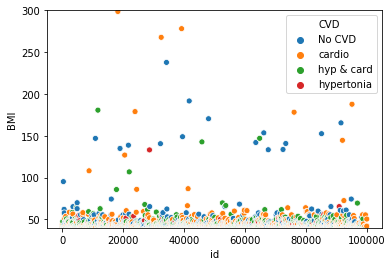

In [41]:
plt.ylim(40, 300)
sns.scatterplot(x="id", y="BMI",
                     hue="CVD",
                     data=cardio_train)

Мы видим, что действительно среди людей, со значительным превышением массы тела(ИМТ>40) имеются случаи, в котором сочетаются гипертония и заболевания сердца и чисто сердечные заболевания (особенно у "рекордсменов" с ИМТ > 250), но тем не менее всего один случай чистой гипертонии и достаточно много случаев, когда ИМТ не сопровождается наличием ССЗ. 